<a href="https://colab.research.google.com/github/martin-fabbri/colab-notebooks/blob/master/causal-inference/dowhy_conditional_treatment_effects_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Conditional Average Treatment Effect (CATE)

This notebook leverages EconML's CATE estimation using different methods.

We will follow the typical doWhy workflow: model, identify, estimate, and refute.

## Setup Dependencies

In [2]:
# !sudo apt install graphviz libgraphviz-dev graphviz-dev pkg-config -y -q

# !pip install -q pygraphviz --install-option="--include-path=/usr/include/graphviz" \
# --install-option="--library-path=/usr/lib/graphviz/"
# !pip install -q dowhy

Reading package lists...
Building dependency tree...
Reading state information...
pkg-config is already the newest version (0.29.1-0ubuntu2).
graphviz is already the newest version (2.40.1-2).
libgraphviz-dev is already the newest version (2.40.1-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.
/usr/local/lib/python3.6/dist-packages/pip/_internal/commands/install.py:283: UserWarning: Disabling all use of wheels due to the use of --build-options / --global-options / --install-options.
  cmdoptions.check_install_build_global(options)
     |████████████████████████████████| 71kB 3.0MB/s 
     |████████████████████████████████| 286kB 15.1MB/s 
     |████████████████████████████████| 5.6MB 21.6MB/s 
     |████████████████████████████████| 71kB 7.3MB/s 
ERROR: econml 0.6.1 has requirement matplotlib<3.1, but you'll have matplotlib 3.1.

In [1]:
import numpy as np
import pandas as pd
import logging

import dowhy
import dowhy.datasets

from IPython.display import Image
from IPython.display import display
from dowhy import CausalModel

import econml
import warnings
warnings.filterwarnings('ignore')

print(dowhy.__version__)

0.2


In [2]:
data = dowhy.datasets.linear_dataset(10, num_common_causes=4, num_samples=10000,
                                     num_instruments=2, num_effect_modifiers=2,
                                     num_treatments=1,
                                     treatment_is_binary=False)
df = data['df']
df.head()

,X0,X1,Z0,Z1,W0,W1,W2,W3,v0,y
0,-0.324569,0.426652,1.0,0.492550,-0.140786,-0.429797,-2.277741,-0.906120,9.744454,104.361311
1,-0.610599,-2.338957,1.0,0.475723,-1.272600,-0.884176,-0.199397,-1.534279,8.868835,9.946754
2,-2.118584,-2.831933,0.0,0.904854,-2.038883,-0.591560,-2.423317,0.379863,8.482439,-1.205740
3,-1.004487,-0.025156,1.0,0.450369,-0.152400,-0.291663,-0.839190,1.845063,18.535579,183.068417
4,-0.722140,-0.306112,1.0,0.314362,-0.860690,-1.094492,-0.826968,-2.144721,3.528292,18.337218


In [3]:
model = CausalModel(data=data['df'],
                    treatment=data['treatment_name'], 
                    outcome=data['outcome_name'],
                    graph=data['gml_graph'])

INFO:dowhy.causal_model:Model to find the causal effect of treatment ['v0'] on outcome ['y']


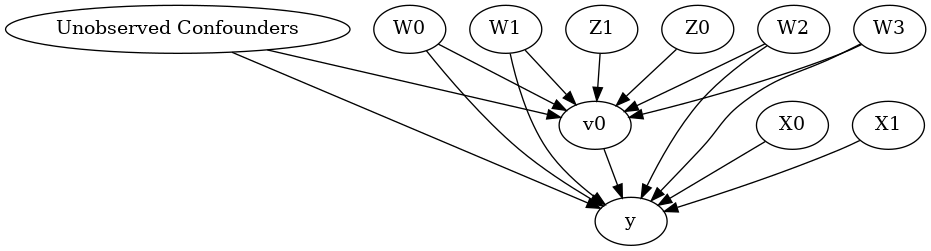

In [4]:
model.view_model()
display(Image(filename='causal_model.png'))

In [5]:
identified_estimand = model.identify_effect()
print(identified_estimand)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['Unobserved Confounders', 'W3', 'W0', 'W2', 'W1']


WARN: Do you want to continue by ignoring any unobserved confounders? (use proceed_when_unidentifiable=True to disable this prompt) [y/n]  y


INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:['Z1', 'Z0']


Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                              
─────(Expectation(y|W3,W0,W2,W1))
d[v₀]                            
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W0,W2,W1,U) = P(y|v0,W3,W0,W2,W1)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z1, Z0])*Derivative([v0], [Z1, Z0])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)



In [7]:
linear_estimate = model.estimate_effect(identified_estimand, 
                                        method_name='backdoor.linear_regression',
                                        control_value=0,
                                        treatment_value=1)
print(linear_estimate)

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W3+W0+W2+W1+v0*X1+v0*X0


*** Causal Estimate ***

## Target estimand
Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                              
─────(Expectation(y|W3,W0,W2,W1))
d[v₀]                            
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W0,W2,W1,U) = P(y|v0,W3,W0,W2,W1)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z1, Z0])*Derivative([v0], [Z1, Z0])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

## Realized estimand
b: y~v0+W3+W0+W2+W1+v0*X1+v0*X0
## Estimate
Value: 10.000000000000012



In [10]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor

dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DMLCateEstimator",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = lambda df: df["X0"]>1,  # condition used for CATE
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(),
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}})
print(dml_estimate)

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v0+W3+W0+W2+W1


*** Causal Estimate ***

## Target estimand
Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                              
─────(Expectation(y|W3,W0,W2,W1))
d[v₀]                            
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W0,W2,W1,U) = P(y|v0,W3,W0,W2,W1)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z1, Z0])*Derivative([v0], [Z1, Z0])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

## Realized estimand
b: y~v0+W3+W0+W2+W1
## Estimate
Value: 9.338474593963495



In [11]:
print("True causal estimate is", data["ate"])

True causal estimate is 8.676774594350668


In [13]:
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DMLCateEstimator",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = 1,  # condition used for CATE
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(),
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}})
print(dml_estimate)

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v0+W3+W0+W2+W1


*** Causal Estimate ***

## Target estimand
Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                              
─────(Expectation(y|W3,W0,W2,W1))
d[v₀]                            
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W0,W2,W1,U) = P(y|v0,W3,W0,W2,W1)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z1, Z0])*Derivative([v0], [Z1, Z0])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

## Realized estimand
b: y~v0+W3+W0+W2+W1
## Estimate
Value: 8.567389258782594



In [14]:

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
dml_estimate = model.estimate_effect(identified_estimand,
                                     method_name="backdoor.econml.dml.DMLCateEstimator",
                                     target_units = lambda df: df["X0"]>1,
                                     confidence_intervals=True,
                                     method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(),
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{
                                                               'inference': 'bootstrap',
                                                            }
                                              })
print(dml_estimate)
print(dml_estimate.cate_estimates[:10])
print(dml_estimate.effect_intervals)

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v0+W3+W0+W2+W1
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.3min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished


*** Causal Estimate ***

## Target estimand
Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                              
─────(Expectation(y|W3,W0,W2,W1))
d[v₀]                            
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W0,W2,W1,U) = P(y|v0,W3,W0,W2,W1)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z1, Z0])*Derivative([v0], [Z1, Z0])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

## Realized estimand
b: y~v0+W3+W0+W2+W1
## Estimate
Value: 9.415270217972697

[[ 2.19817057]
 [ 7.46175347]
 [ 9.51961415]
 [13.95523177]
 [ 8.24191967]
 [12.01612854]
 [13.16924298]
 [10.37607371]
 [11.04974676]
 [ 9.77446704]]
(array([[ 2.09214203],
       [ 7.27949974],
       [ 9.26638652],
       [13.53309676],
       [ 8.0179526 ],
       [11.68007387],
       [12.727185

In [15]:
test_cols= data['effect_modifier_names'] # only need effect modifiers' values
test_arr = [np.random.uniform(0,1, 10) for _ in range(len(test_cols))] # all variables are sampled uniformly, sample of 10
test_df = pd.DataFrame(np.array(test_arr).transpose(), columns=test_cols)
dml_estimate = model.estimate_effect(identified_estimand,
                                     method_name="backdoor.econml.dml.DMLCateEstimator",
                                     target_units = test_df,
                                     confidence_intervals=False,
                                     method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(),
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}
                                              })
print(dml_estimate.cate_estimates)

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v0+W3+W0+W2+W1


[[10.17788257]
 [11.00910167]
 [12.72347332]
 [11.46475324]
 [11.37371759]
 [12.66128756]
 [11.85350361]
 [10.44221946]
 [11.0080109 ]
 [12.29467385]]


In [ ]:
print(dml_estimate._estimator_object)
dml_estimate